## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import sklearn
import scipy
import seaborn as sns

In [2]:
import matplotlib
matplotlib.rcParams["image.origin"] = 'upper'

In [3]:
import tqdm
#from tqdm import tqdm
from tqdm.notebook import tqdm # for notebooks
tqdm.pandas()

In [4]:
import pickle
import gc
collectAll = lambda : gc.collect(0) + gc.collect(1) + gc.collect(2)

In [5]:
from collections import namedtuple
import itertools
from itertools import product

In [6]:
from skimage.feature import graycomatrix
from skimage.feature import graycoprops
from math import pi

In [7]:
import PIL as pil
from PIL import Image, ImageDraw

In [8]:
import math

In [9]:
import sys
import os

In [10]:
import functools

In [11]:
import torch
import torchvision

In [12]:
from einops import *

In [13]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [14]:
import networkx as nx

In [15]:
from pathlib import Path

In [16]:
import umap
#Note: VERY HACKY: Manually fixed broken deps install.
import umap.plot
from umap import UMAP

E:\miniconda3\envs\up-to-date-env\Lib\site-packages\umap\plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [17]:
import glasbey

# Load our captures

In [18]:
df = pd.read_pickle('df_unified.pickle')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       80 non-null     object
 1   ymin       80 non-null     int64 
 2   ymax       80 non-null     int64 
 3   xmin       80 non-null     int64 
 4   xmax       80 non-null     int64 
 5   src        80 non-null     object
 6   tree_name  80 non-null     object
 7   crop       80 non-null     object
dtypes: int64(4), object(4)
memory usage: 5.1+ KB


# Plot the pixel value distributions

Let's confirm first that all of our crops have 9 spectral bands present, as a sanity check.

In [20]:
df['crop'].apply(lambda x: x.shape[-1]).unique()

array([9], dtype=int64)

## Obtain per-pixel data

In [21]:
bands = ['wr', 'wg', 'wb', 'r', 'g', 'b', 'nir', 'red_edge', 'ndvi']

bands_readable = {
    'wr': 'Wideband Red',
    'wg': 'Wideband Blue',
    'wb': 'Wideband Green',
    'r': 'Narrowband Red',
    'g': 'Narrowband Blue',
    'b': 'Narrowband Green',
    'nir': 'Near-Infrared',
    'red_edge': 'Red-Edge',
    'ndvi': 'NDVI'
}

In [22]:
df_px = df.copy()
for band in bands:
    df_px[band] = df['crop'].apply(lambda x: x[:,:,bands.index(band)].flatten())
df_px = df_px.drop('crop', axis=1)

In [23]:
df_px = df_px.explode(bands)

In [24]:
df_px = df_px.astype({band: 'float32' for band in bands})

In [25]:
df_px = df_px.reset_index(drop=True)

In [26]:
df_px.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9483213 entries, 0 to 9483212
Data columns (total 16 columns):
 #   Column     Dtype  
---  ------     -----  
 0   name       object 
 1   ymin       int64  
 2   ymax       int64  
 3   xmin       int64  
 4   xmax       int64  
 5   src        object 
 6   tree_name  object 
 7   wr         float32
 8   wg         float32
 9   wb         float32
 10  r          float32
 11  g          float32
 12  b          float32
 13  nir        float32
 14  red_edge   float32
 15  ndvi       float32
dtypes: float32(9), int64(4), object(3)
memory usage: 832.0+ MB


## Band values in Chestnut vs in Casuarina

In [27]:
df_px['src'].unique()

array(['93deg', '183deg', '10May2021', '18Dec2020'], dtype=object)

In [28]:
df_px_chestnut = df_px[df_px['src'].isin(['10May2021', '18Dec2020'])]
df_px_casuarina = df_px[df_px['src'].isin(['93deg', '183deg'])]

In [29]:
print("# of Chestnut pixels: {:,}\n# of Casuarina pixels: {:,}".format(
    len(df_px_chestnut), len(df_px_casuarina)))

# of Chestnut pixels: 7,884,618
# of Casuarina pixels: 1,598,595


Text(0.5, 0.98, 'Band values in Chestnut vs in Casuarina, after cropping out ITCs')

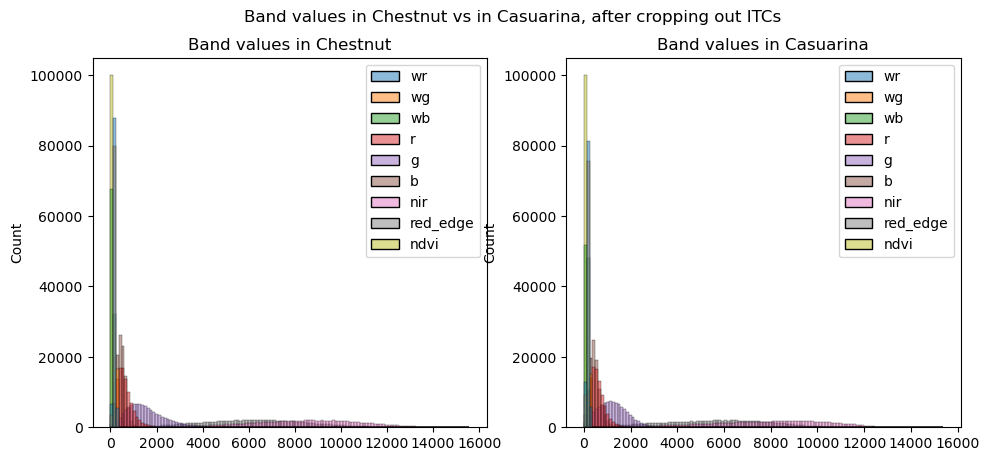

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8*1))
sns.histplot(data = df_px_chestnut.sample(100_000)[bands],
             bins=128,
             ax=ax[0],
             log_scale=False)
sns.histplot(data = df_px_casuarina.sample(100_000)[bands],
             bins=128,
             ax=ax[1],
             log_scale=False)
ax[0].set_title('Band values in Chestnut')
ax[1].set_title('Band values in Casuarina')
fig.suptitle("Band values in Chestnut vs in Casuarina, after cropping out ITCs")

Text(0.5, 0.98, 'Band values in Chestnut vs in Casuarina, after cropping out ITCs')

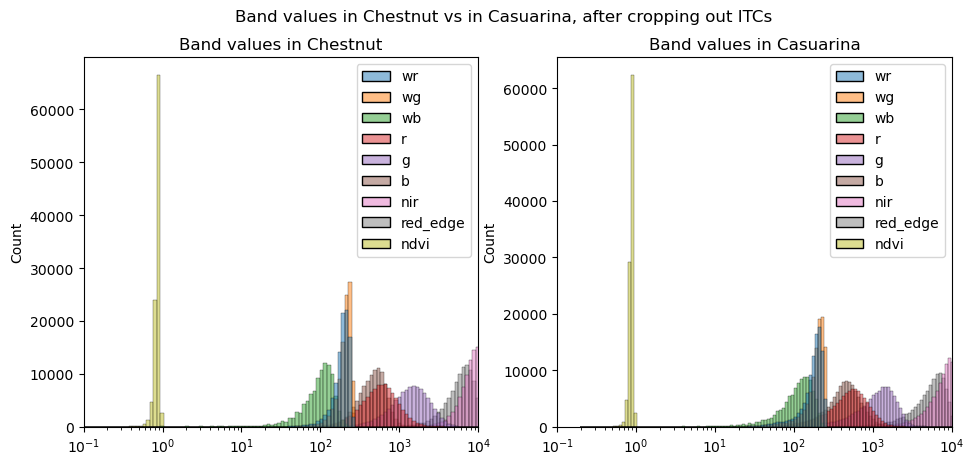

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(5.6*2, 4.8*1))
sns.histplot(data = df_px_chestnut.sample(100_000)[bands],
             bins=128,
             ax=ax[0],
             log_scale=True)
sns.histplot(data = df_px_casuarina.sample(100_000)[bands],
             bins=128,
             ax=ax[1],
             log_scale=True)
ax[0].set_title('Band values in Chestnut')
ax[1].set_title('Band values in Casuarina')
ax[0].set_xlim(10**-1, 10**4)
ax[1].set_xlim(10**-1, 10**4)
fig.suptitle("Band values in Chestnut vs in Casuarina, after cropping out ITCs")

## Band values per species

In [32]:
species = list(df['name'].unique())
print(species)

['Campnosperma Auriculatum', 'Palm Tree', 'Macaranga Gigantea', 'Falcataria Moluccana', 'Ficus Variegata', 'Bridelia Sp.', 'Spathodea Campanulatum', 'Terminalia Catappa', 'Shorea Leprosula', 'Syzygium Polyanthum', 'Cinnamomum Iners', 'Clausena Excavata', 'Alstonia Angulstiloba', 'Sandoricum Koetjape', 'Sterculia Parviflora', 'Claoxylon Indicum', 'Pometia Pinnata', 'Calophyllum', 'Pennisetum Purpureum', 'Dillenia Suffruticosa', 'Cratoxylum Formosum']


In [33]:
species_palette = glasbey.create_palette(palette_size=len(species))

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Band values per species, 64 bins due to discontinuities')

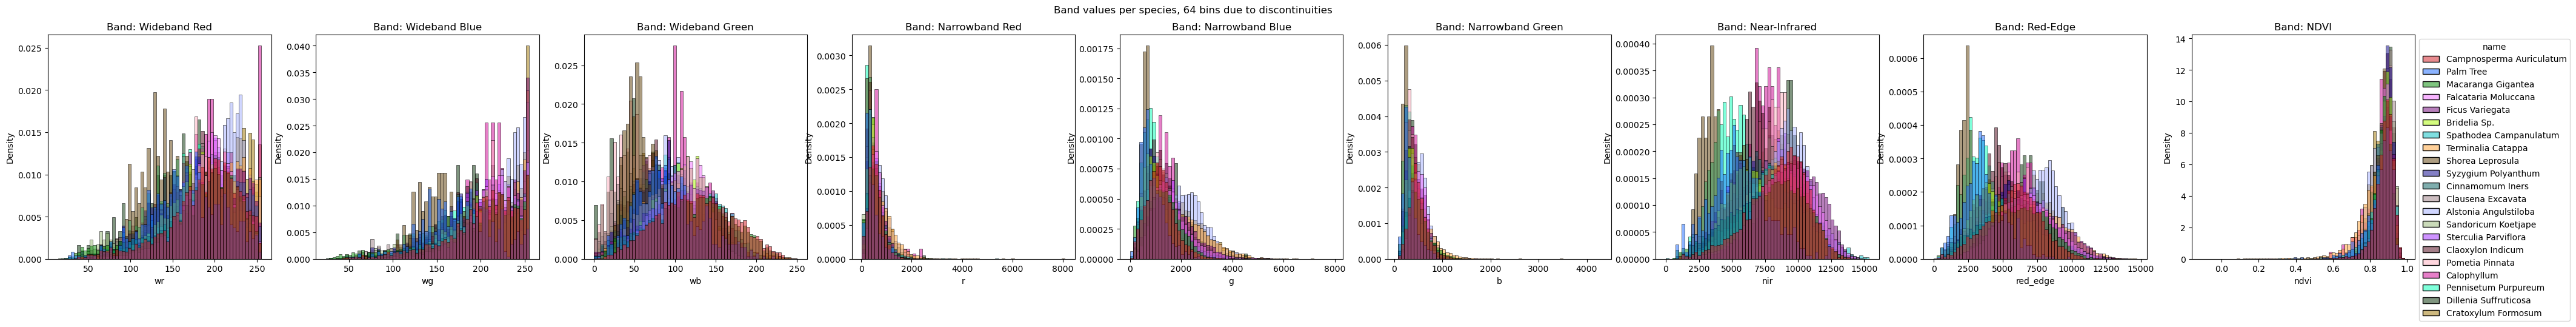

In [34]:
fig, ax = plt.subplots(nrows := 1, ncols := len(bands), figsize=(5.6*ncols, 4.8*nrows))
for band, col in tqdm(zip(bands, ax.flatten()), total=len(bands)):
    sns.histplot(
        data=df_px[['name', band]].sample(100_000),
        x=band,
        hue='name',
        hue_order=species,
        bins=64,
        stat='density',
        common_norm=False,
        palette=species_palette,
        #alpha=0.20,
        #element="step",
        #fill=False,
        legend=False if col is not ax.flatten()[-1] else True,
        ax=col
    )
    if col is ax.flatten()[-1]:
        sns.move_legend(col, "upper left", bbox_to_anchor=(1, 1))
    col.set_title("Band: {}".format(bands_readable[band]))
fig.suptitle("Band values per species, 64 bins due to discontinuities")

## Band values for the different Campnospermum samples

In [35]:
df_px_campnospermum = df_px[df_px['name'] == 'Campnosperma Auriculatum']
df_px_campnospermum = df_px_campnospermum.copy()

In [36]:
df_px_campnospermum['tree_label'] = df_px_campnospermum.progress_apply(lambda x: str((x['src'], x['tree_name'])),
                                                                       axis=1)

  0%|          | 0/690286 [00:00<?, ?it/s]

In [37]:
len(df_px_campnospermum)

690286

In [38]:
tree_labels = list(df_px_campnospermum['tree_label'].unique())
print(tree_labels)

["('93deg', 'Campnosperma N')", "('93deg', 'Campnosperma S')", "('183deg', 'Campnosperma N')", "('183deg', 'Campnosperma S')", "('183deg', 'Campnosperma E')", "('93deg', 'Campnosperma E')", "('10May2021', 'Campnosperma Auriculatum #0')", "('18Dec2020', 'Campnosperma Auriculatum #1')"]


In [39]:
df_px_non_campnospermum = df_px[df_px['name'] != 'Campnosperma Auriculatum']
df_px_non_campnospermum = df_px_non_campnospermum.sample(int(len(df_px_campnospermum) / len(tree_labels)))
df_px_non_campnospermum['tree_label']= 'NON-CAMPAU'

In [40]:
df_px_campnospermum = pd.concat((df_px_campnospermum, df_px_non_campnospermum))

In [41]:
tree_labels = list(df_px_campnospermum['tree_label'].unique())
print(tree_labels)

["('93deg', 'Campnosperma N')", "('93deg', 'Campnosperma S')", "('183deg', 'Campnosperma N')", "('183deg', 'Campnosperma S')", "('183deg', 'Campnosperma E')", "('93deg', 'Campnosperma E')", "('10May2021', 'Campnosperma Auriculatum #0')", "('18Dec2020', 'Campnosperma Auriculatum #1')", 'NON-CAMPAU']


In [42]:
tree_labels_palette = glasbey.create_palette(palette_size=len(tree_labels))

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Band values per Campnosperma sample, 64 bins due to discontinuities\nSamples of "NON-CAMPAU" added for comparison')

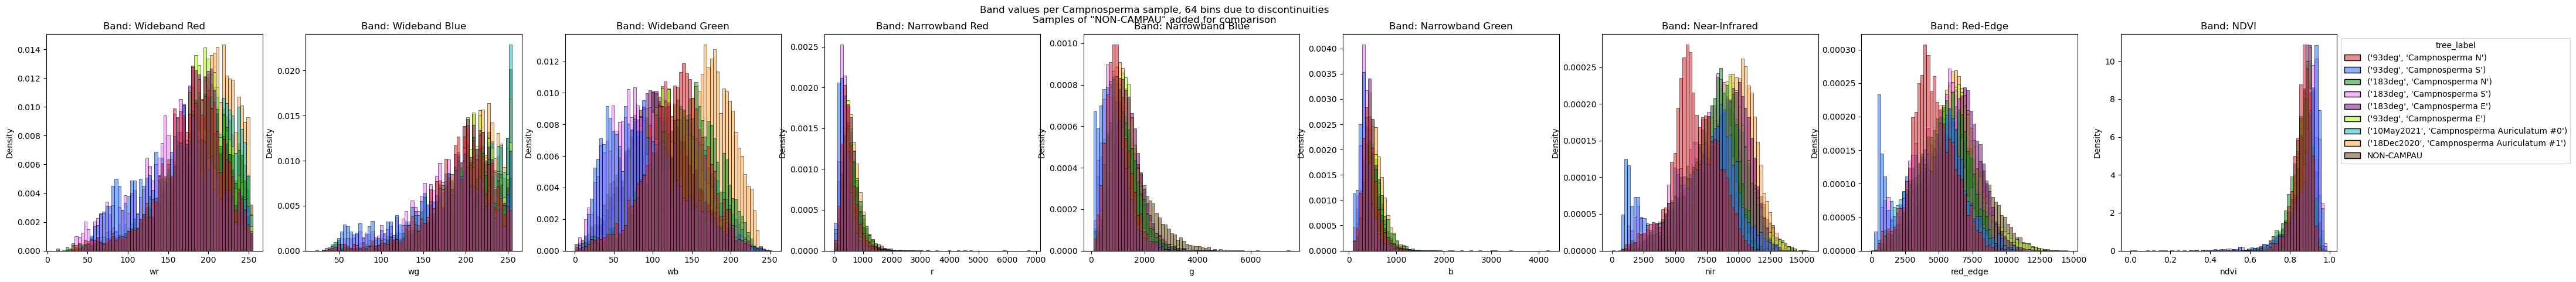

In [43]:
fig, ax = plt.subplots(nrows := 1, ncols := len(bands), figsize=(5.6*ncols, 4.8*nrows))
for band, col in tqdm(zip(bands, ax.flatten()), total=len(bands)):
    sns.histplot(
        data=df_px_campnospermum[['tree_label', band]].sample(100_000),
        x=band,
        hue='tree_label',
        hue_order=tree_labels,
        bins=64,
        stat='density',
        common_norm=False,
        palette=tree_labels_palette,
        #alpha=0.20,
        #element="step",
        #fill=False,
        legend=False if col is not ax.flatten()[-1] else True,
        ax=col
    )
    if col is ax.flatten()[-1]:
        sns.move_legend(col, "upper left", bbox_to_anchor=(1, 1))
    col.set_title("Band: {}".format(bands_readable[band]))
fig.suptitle("Band values per Campnosperma sample, 64 bins due to discontinuities\nSamples of \"NON-CAMPAU\" added for comparison")